# This notebook focus on the analysis of **Football Tracking data** made available by **SkillCorner**

Some of the explored topics in this notebook are: Ball possession, Players Heatmap and Game stats extraction

The data can be accessed here: https://github.com/SkillCorner/opendata.
<br>
The frame plots were made based on Laurie vizualization code (https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking).

## Load data

In [1]:
import json

import LaurieOnTracking_SourceCode.Metrica_Viz as mviz

import matplotlib.pyplot as plt
import numpy as np
import math

import time
import matplotlib.cm as cm

import cv2
import glob

import pandas as pd

In [2]:

with open('opendata-master/data/matches.json') as f:
    matches = json.load(f)

with open('opendata-master/data/matches/3442/match_data.json') as f:
    match_data = json.load(f)
    
with open('opendata-master/data/matches/3442/structured_data.json') as f:
    structured_data = json.load(f)


## Plot a given frame

Based on the players positions, the match frames will be plotted using Laurie code, obtained from https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking

In [3]:
def get_players_name(data):
    p_names_ids = {}
    
    for p in data:
        n = p['last_name']
        p_names_ids[n] = p['trackable_object']
    return p_names_ids


def get_players_details(data):
    p_numbers = {}
    for p in data:
        if p['team_id'] == match_data['home_team']['id']:
            p_numbers[p['trackable_object']] = [0, p['number']]
        elif p['team_id'] == match_data['away_team']['id']:
            p_numbers[p['trackable_object']] = [1, p['number']]
    return p_numbers


#convert data into Laurie sturcture, in order to call his function
def convert_format(frame_data, player_details, home_team = 0):
    new_format = pd.Series()
    
    new_format.at['Period'] = frame_data['period']
    new_format.at['Time [s]'] = frame_data['time']
    
    for p in frame_data['data']:
        
        if 'trackable_object' not in p:
            continue
            
        #ball
        elif p['trackable_object'] == 55:
            new_format.at['ball_x'] = p['x']
            new_format.at['ball_y'] = p['y']
            
        #referee
        #elif p['trackable_object'] == 11513:
        elif p['trackable_object'] == 11331:
            continue
            
        #players of desired team
        elif player_details[p['trackable_object']][0] == home_team:
            new_format.at['Home_' + str(player_details[p['trackable_object']][1]) + '_x'] = p['x']
            new_format.at['Home_' + str(player_details[p['trackable_object']][1]) + '_y'] = p['y']
    
    #default ball position is on the center of the field
    if 'ball_x' not in new_format or 'ball_y' not in new_format:
        new_format.at['ball_x'] = 0
        new_format.at['ball_y'] = 0
        
    
    return new_format
    

def plot_frame(frame_data):
    frame_data = structured_data[17700]

    player_details = get_players_details(match_data['players'])

    home_data = convert_format(frame_data, player_details, 0)
    away_data = convert_format(frame_data, player_details, 1)

    print('Time: ', home_data['Time [s]'])

    fig,ax = mviz.plot_frame(home_data, away_data, annotate=True)
    plt.show()


Time:  27:54.10


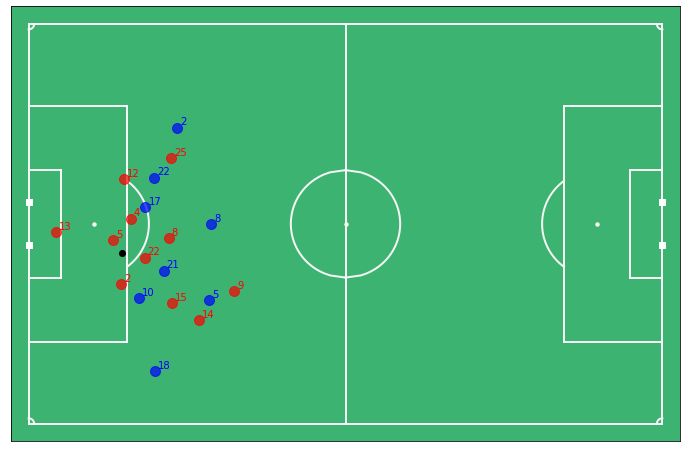

In [4]:
#Plot football frame

plot_frame(structured_data)

**Play and Save Sequence of Frames**

In [60]:
#Create video from images on path
def save_play(name, path, fps):

    img_array = []
    for filename in sorted(glob.glob(path)):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'MP4V'), fps, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

#Create images and then produce video of the game play for interval of frames [init_f, end_f]
def run_football_move(structured_data, match_data, init_f, end_f, fps, path):
    
    for ind, f in enumerate(range(init_f, end_f, fps)):

        frame_data = structured_data[f]

        player_details = get_players_details(match_data['players'])

        home_data = convert_format(frame_data, player_details, 1)
        away_data = convert_format(frame_data, player_details, 0)

        fig,ax = mviz.plot_frame(home_data, away_data, annotate=True)

        # place a text box in upper left in axes coords
        textstr = 'Time: ' + home_data['Time [s]']
        props = dict(boxstyle='round', facecolor='#eeefff', alpha=0.7)
        ax.text(0.04, 0.94, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)


        plt.savefig(path + "/file%04d.png" % ind)
        
        plt.clf()
        plt.close()
    
    plt.clf()
    plt.close()
    
    save_play('play_move.mp4', path+'/*.png', int(10/fps))
    
plt.clf()
plt.close()

run_football_move(structured_data, match_data, 17700, 18000, 2, "path/imgs")

## Possession Analysis

In [5]:

# count the number of frames in which is player has the ball possession
p_counter = {}
for f in structured_data:
    
    t_obj = f['possession']['trackable_object']
    
    if t_obj != None:
        
        if t_obj not in p_counter:
            p_counter[t_obj] = 0
        else:
            p_counter[t_obj] += 1

# create a dataframe with the percentage of possession of each player
possession_df = pd.DataFrame([], columns=['Name', 'Possession', 'TeamId'])

for p in match_data['players']:
    if p['trackable_object'] in list(p_counter.keys()):
        n = p['first_name'] + ' ' + p['last_name']
        n = n.strip()
        #n = p['last_name']
        
        new_row = {'Name': n, 'Possession': p_counter[p['trackable_object']], 'TeamId': p['team_id']}
        
        possession_df = possession_df.append(new_row, ignore_index=True)

#convert into percentage
possession_df['Possession'] = possession_df['Possession']/possession_df['Possession'].sum()

#sort and re-index dataframe
possession_df.sort_values(by=['Possession'], ascending=False, inplace=True)
possession_df.reset_index(inplace=True, drop=True)

possession_df.head()

,Name,Possession,TeamId
0,Gerard Pique,0.102028,264
1,Samuel Umtiti,0.0982704,264
2,Frenkie de Jong,0.0697674,264
3,Marcelo,0.0636782,262
4,Toni Kroos,0.0626417,262


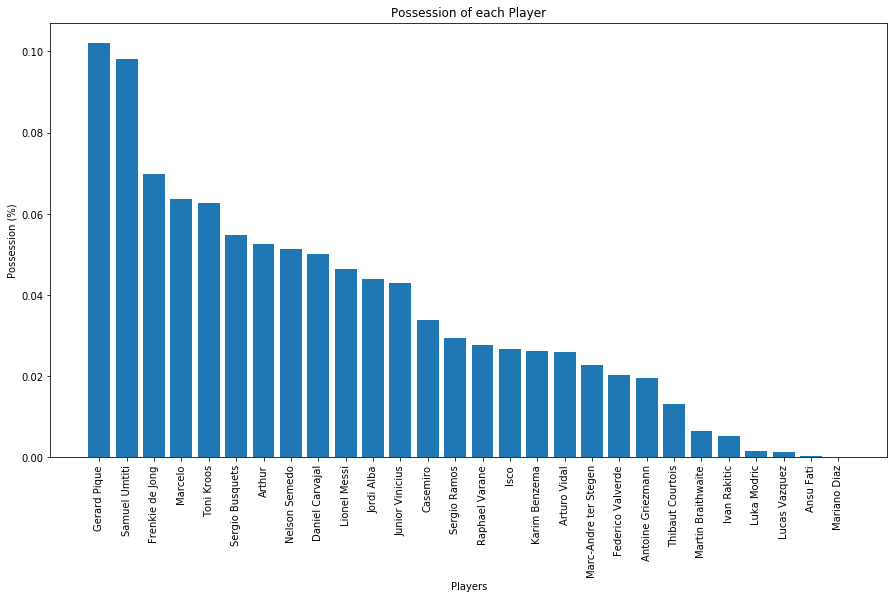

In [6]:
#Plot Players Possessions

plt.figure(figsize=(15, 8))
plt.bar(possession_df['Name'], possession_df['Possession'])
plt.title('Possession of each Player')
plt.xticks(rotation=90)
plt.ylabel('Possession (%)')
plt.xlabel('Players')
plt.show()

## Frequency Heat Map

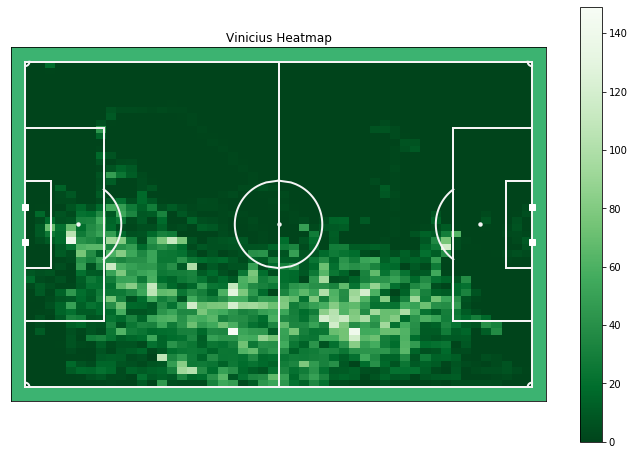

In [7]:
#plot heat map
def plot_heatmap(p_id, data):
    
    xx = np.array([])
    yy = np.array([])
    for f in data:
        if len(f['data']) == 0:
            continue
            
        for p in f['data']:
            if 'trackable_object' in p and p['trackable_object'] == p_id:
                if f['period'] == 1:
                    xx = np.append(xx, -p['x'])
                    yy = np.append(yy, -p['y'])
                    
                elif f['period'] == 2:
                    xx = np.append(xx, p['x'])
                    yy = np.append(yy, p['y'])
                
    
    return xx, yy

p_names_ids = get_players_name(match_data['players'])

p_name = 'Vinicius'
p_id = p_names_ids[p_name]

#get xx and yy data of a given player
xx, yy = plot_heatmap(p_id, structured_data)


#plot heatmap
field_dim = (106.0,68.0)
heatmap, xedges, yedges = np.histogram2d(xx, yy, bins=50)
extent = [-field_dim[0]/2, field_dim[0]/2, -field_dim[1]/2, field_dim[1]/2]

fig, ax = mviz.plot_pitch(field_dimen = field_dim)

img = ax.imshow(heatmap.T, cmap='Greens_r', extent=extent, origin='lower')
fig.colorbar(img)

ax.set_title(p_name + ' Heatmap')

plt.show()

## Football Stats Extraction - Work in Progress

Based on the tracking data, some stats will be extracted, namelly ***ball possession, shots, shots on target, corners and passes***

In [8]:
def find_play_directions(data):
    home_team_start, left_to_right = 'away team', 0

    for s in data:
        if s['time'] == '0:00.00':

            if s['possession']['group'] == 'home team':
                home_team_start = 'home team'

            if s['data'][0]['x'] < 0:
                left_to_right = 1
    
    return home_team_start, left_to_right
 
    
home_team_start, left_to_right = find_play_directions(structured_data)

### Ball Possession


In [9]:
possession_df.groupby('TeamId')['Possession'].sum().round(3)

TeamId
262    0.4
264    0.6
Name: Possession, dtype: float64

### Shots

It is considered a shot if:
- the ball crosses the final line
- the last player in possession of the ball is of the attacking team
- the ball approaches the final line with a given speed (>10 m/s)

In [10]:

#return ball position for moves with someone in possession
def get_ball_moves(data):
    
    pos = {}
    
    for s in data:
        
        for f in s['data']:
            
            if 'trackable_object' in f and f['trackable_object'] == 55 and s['possession']['group'] != None:
                
                if f['track_id'] in pos:
                    pos[f['track_id']]['x_y'].append([f['x'], f['y']])
                    pos[f['track_id']]['time'] = s['time']
                else:
                    pos[f['track_id']] = {}
                    pos[f['track_id']]['poss'] = s['possession']
                    pos[f['track_id']]['period'] = s['period']
                    pos[f['track_id']]['x_y'] = [[f['x'], f['y']]]
                    
    
    return pos

ball_moves = get_ball_moves(structured_data)

In [14]:
def is_whitin_interval(y, yy):
    for x in yy:
        if y[0] < x < y[1]:
            return True
    return False

n_shots = {
    'home team': 0,
    'away team': 0,
    None: 0
}

n_shots_on_target = {
    'home team': 0,
    'away team': 0,
    None: 0
}

def compute_ball_speed(pos):
    max_speed = 0
    initial_pos = pos[0,:]
    
    for i in range(1, len(pos), 10):
        
        dist = np.linalg.norm(pos[i,:] - initial_pos)
        v = dist/1        
        
        if v > max_speed:
            max_speed = v
        
        initial_pos = pos[i,:]
        
    return max_speed


goal_dist = 7.3
goal_yy = [-goal_dist/2, goal_dist/2]
on_target_threshold = 0.5

dist_threshold = 52.5
max_speed = 10

for k in ball_moves:
    move = ball_moves[k]
    
    #convert into numpy array
    move['x_y'] = np.array(move['x_y'])
    
    xx = np.array(move['x_y'][:, 0])
    yy = np.array(move['x_y'][:, 1])
    
    
    if compute_ball_speed(move['x_y']) < max_speed:
        continue
        
    elif home_team_start == move['poss']['group'] and left_to_right == 1 and move['period'] == 1:
        #greater than dist_threshold
        if np.any(xx >= dist_threshold - on_target_threshold) and is_whitin_interval(goal_yy, yy):
            n_shots_on_target[move['poss']['group']] += 1
            print("Shot on Target - Real Madrid - Left_Right - Period 1 - Time: ", move['time'])
        elif np.any(xx >= dist_threshold):
            n_shots[move['poss']['group']] += 1
            print("Shot - Real Madrid - Left_Right - Period 1 - Time: ", move['time'])
        
    elif home_team_start == move['poss']['group'] and left_to_right == 1 and move['period'] == 2:
        #lesser than dist_threshold
        if np.any(xx <= -dist_threshold + on_target_threshold) and is_whitin_interval(goal_yy, yy):
            n_shots_on_target[move['poss']['group']] += 1
            print("Shot On Target - Real Madrid - Left_Right - Period 2 - Time: ", move['time'])
        elif np.any(xx <= -dist_threshold):
            n_shots[move['poss']['group']] += 1
            print("Shot - Real Madrid - Left_Right - Period 1 - Time: ", move['time'])
        
        
        
    elif home_team_start == move['poss']['group'] and left_to_right == 0 and move['period'] == 1:
        #lesser than -dist_threshold
        if np.any(xx <= -dist_threshold + on_target_threshold) and is_whitin_interval(goal_yy, yy):
            n_shots_on_target[move['poss']['group']] += 1
            print("Shot On Target - Real Madrid - Right_Left - Period 1 - Time: ", move['time'])
        elif np.any(xx <= -dist_threshold):
            n_shots[move['poss']['group']] += 1
            print("Shot - Real Madrid - Right_Left - Period 1 - Time: ", move['time'])
            
    elif home_team_start == move['poss']['group'] and left_to_right == 0 and move['period'] == 2:
        #greater than dist_threshold
        if np.any(xx >= dist_threshold - on_target_threshold) and is_whitin_interval(goal_yy, yy):
            n_shots_on_target[move['poss']['group']] += 1
            print("Shot On Target - Real Madrid - Right_Left - Period 2 - Time: ", move['time'])
        elif  np.any(xx >= dist_threshold):
            n_shots[move['poss']['group']] += 1
            print("Shot - Real Madrid - Right_Left - Period 2 - Time: ", move['time'])
        
        
        
    elif home_team_start != move['poss']['group'] and left_to_right == 1 and move['period'] == 1:
        #lesser than -dist_threshold
        if np.any(xx <= -dist_threshold + on_target_threshold) and is_whitin_interval(goal_yy, yy):
            n_shots_on_target[move['poss']['group']] += 1
            print("Shot On Target - Barca - Left_Right - Period 1 - Time: ", move['time'])
        elif np.any(xx <= -dist_threshold):
            n_shots[move['poss']['group']] += 1
            print("Shot - Barca - Left_Right - Period 1 - Time: ", move['time'])
            
    elif home_team_start != move['poss']['group'] and left_to_right == 1 and move['period'] == 2:
        #greater than dist_threshold
        if np.any(xx >= dist_threshold - on_target_threshold) and is_whitin_interval(goal_yy, yy):
            n_shots_on_target[move['poss']['group']] += 1
            print("Shot On Target - Barca - Left_Right - Period 2 - Time: ", move['time'])
        elif  np.any(xx >= dist_threshold):
            n_shots[move['poss']['group']] += 1
            print("Shot - Barca - Left_Right - Period 2 - Time: ", move['time'])
        
        
        
    elif home_team_start != move['poss']['group'] and left_to_right == 0 and move['period'] == 1:
        #greater than dist_threshold
        if np.any(xx >= dist_threshold - on_target_threshold) and is_whitin_interval(goal_yy, yy):
            n_shots_on_target[move['poss']['group']] += 1
            print("Shot On Target - Barca - Right_Left - Period 1 - Time: ", move['time'])
        elif  np.any(xx >= dist_threshold):
            n_shots[move['poss']['group']] += 1
            print("Shot - Barca - Right-Left - Period 1 - Time: ", move['time'])
            
    elif home_team_start != move['poss']['group'] and left_to_right == 0 and move['period'] == 2:
        #lesser than -dist_threshold
        if np.any(xx <= -dist_threshold + on_target_threshold) and is_whitin_interval(goal_yy, yy):
            n_shots_on_target[move['poss']['group']] += 1
            print("Shot On Target - Barca - Right_Left - Period 2 - Time: ", move['time'])
        elif np.any(xx <= -dist_threshold):
            n_shots[move['poss']['group']] += 1
            print("Shot - Barca - Right_Left - Period 1 - Time: ", move['time'])
         
    
print(f"\nNumber of shots of each team: {n_shots}")

Shot on Target - Real Madrid - Left_Right - Period 1 - Time:  0:55.10
Shot on Target - Real Madrid - Left_Right - Period 1 - Time:  11:39.90
Shot On Target - Barca - Left_Right - Period 1 - Time:  17:58.10
Shot on Target - Real Madrid - Left_Right - Period 1 - Time:  33:08.10
Shot - Barca - Left_Right - Period 1 - Time:  34:25.20
Shot On Target - Real Madrid - Left_Right - Period 2 - Time:  59:37.40
Shot - Real Madrid - Left_Right - Period 1 - Time:  67:40.00
Shot On Target - Barca - Left_Right - Period 2 - Time:  69:42.90
Shot - Real Madrid - Left_Right - Period 1 - Time:  80:42.50

Number of shots of each team: {'home team': 2, 'away team': 1, None: 0}


*Work In Progress*